# Attention Mechanisms


As discussed in the [notes](./attention.md), Attention is a mechanism that addresses the information bottleneck in fixed-size vector representations (like in standard RNNs) by allowing the model to "look back" at the entire input sequence at each decoding step. This notebook implements two common types of attention: **Additive (Bahdanau)** and **Multiplicative/General (Luong)**, and compares them against vanilla RNN, LSTM, and GRU baselines on a synthetic "needle-in-a-haystack" task.

In [10]:
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import trange
import torch.nn as nn
import numpy as np
import random
import torch
import torch.nn.functional as F

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

## Data Generation

We use the same synthetic task as in the [RNN notebook](./rnn.ipynb): a classification task where the informative keyword (`great` or `awful`) is placed at the *beginning* of a long sequence of filler words. The model must learn to propagate this information across the entire sequence (or "attend" back to it) to make the correct prediction at the end.

In [11]:
SEQ_LEN = 50
VOCAB_SIZE = 1000
EMBED_SIZE = 32
HIDDEN_SIZE = 64
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 500

PAD_TOKEN = "<pad>"
POS_TOKEN = "great"
NEG_TOKEN = "awful"
UNK_TOKEN = "<unk>"
special_tokens = [PAD_TOKEN, POS_TOKEN, NEG_TOKEN, UNK_TOKEN]

filler_words_in_vocab = [f"word_{i}" for i in range(VOCAB_SIZE - len(special_tokens))]
final_word_list = special_tokens + filler_words_in_vocab
vocab = {word: i for i, word in enumerate(final_word_list)}
FINAL_VOCAB_SIZE = len(vocab)
unk_idx = vocab[UNK_TOKEN]

print(f"Actual vocab size: {FINAL_VOCAB_SIZE}")

def generate_batch(batch_size=BATCH_SIZE, seq_len=SEQ_LEN):
    batch_X = []
    batch_Y = []
    for _ in range(batch_size):
        if random.random() > 0.5:
            label = 1  
            keyword = POS_TOKEN
        else:
            label = 0
            keyword = NEG_TOKEN

        # Keyword at the start, followed by fillers
        sequence = [keyword] + [
            random.choice(filler_words_in_vocab) for _ in range(seq_len - 1)
        ]
        seq_indices = [vocab.get(word, unk_idx) for word in sequence]
        batch_X.append(seq_indices)
        batch_Y.append(label)

    X_tensor = torch.LongTensor(batch_X)
    Y_tensor = torch.LongTensor(batch_Y) 
    return X_tensor, Y_tensor

Actual vocab size: 1000


## Models

We will implement and compare 5 models:
1.  **Simple RNN**: Vanilla RNN, prone to vanishing gradients.
2.  **LSTM**: Long Short-Term Memory, better gradients but still fixed-size bottleneck.
3.  **GRU**: Gated Recurrent Unit, similar to LSTM but more efficient.
4.  **Additive Attention RNN**: Uses a learned alignment function (MLP) to compute attention scores.
5.  **Multiplicative Attention RNN**: Uses general dot product (with weight matrix) to compute attention scores.

Note that we will be using torch here cuz I cba modifying the ones we had in rnn.ipynb.
Since we're using torch's stuff now, a lot of it is going to be done done via the concatenated version of the operations.
Which *are* faster for parallelized computation, and *are* equal, but we now have to slice up the matrices. 
So that's what I'm doing down there.


In [12]:
# Baselines (from rnn.ipynb)

class SimpleRNNModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=vocab[PAD_TOKEN])
        self.rnn = nn.RNN(embed_size, hidden_size, batch_first=True)
        self.h2y = nn.Linear(hidden_size, 2)


    def forward(self, x, return_attn=False):
        # return_attn is just API compatibility, RNNs don't have attention
        embedded = self.embedding(x)
        output, h_n = self.rnn(embedded)
        # Take the last time step's output
        last_output = output[:, -1, :]
        prediction = self.h2y(last_output)
        if return_attn:
             return prediction, None # returning raw logits for ce
        return prediction

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=vocab[PAD_TOKEN])
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.h2y = nn.Linear(hidden_size, 2) 

        
        # Forget bias initialization trick 
        for name, param in self.lstm.named_parameters():
             if "bias" in name:
                 n = param.size(0)
                 start, end = n // 4, n // 2
                 param.data[start:end].fill_(2.0)

    def forward(self, x, return_attn=False):
        embedded = self.embedding(x)
        output, (h_n, c_n) = self.lstm(embedded)
        last_output = output[:, -1, :]
        prediction = self.h2y(last_output)
        if return_attn:
             return prediction, None
        return prediction

class GRUModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=vocab[PAD_TOKEN])
        self.gru = nn.GRU(embed_size, hidden_size, batch_first=True)
        self.h2y = nn.Linear(hidden_size, 2) 

        # Bias initialization trick for GRU update gate 
        for name, param in self.gru.named_parameters():
            if 'bias' in name:
                n = param.size(0)
                start, end = n // 3, 2 * (n // 3)
                param.data[start:end].fill_(2.0) 


    def forward(self, x, return_attn=False):
        embedded = self.embedding(x)
        output, h_n = self.gru(embedded)
        last_output = output[:, -1, :]
        prediction = self.h2y(last_output)
        if return_attn:
             return prediction, None
        return prediction

## Attention Mechanism Implementations

We'll define a generic `AttentionRNN` that takes an `attention_type` argument. The core logic handles:
1.  Encoding the sequence (using an RNN/GRU).
2.  Calculating attention scores (alignment) between the last hidden state (query) and all encoder states (keys).
3.  Computing attention weights (softmax of scores).
4.  Computing the context vector (weighted sum of values, which are the encoder states).
5.  Combining context vector with the query to produce the final component.

**Formulas:**

- **Dot-Product (General):** $e_t = h_t^T W h_i$
- **Additive:** $e_t = v^T \tanh(W_1 h_t + W_2 h_i)$

In [13]:
class AttentionRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, attention_type='dot'):
        super().__init__()
        self.hidden_size = hidden_size
        self.attention_type = attention_type
        
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=vocab[PAD_TOKEN])
        # Using GRU for the encoder, but could be simple RNN
        self.rnn = nn.GRU(embed_size, hidden_size, batch_first=True)
        
        if attention_type == 'additive':
            self.attn_w1 = nn.Linear(hidden_size, hidden_size) # for query
            self.attn_w2 = nn.Linear(hidden_size, hidden_size) # for keys
            self.attn_v = nn.Linear(hidden_size, 1, bias=False)
        elif attention_type == 'dot':
            # Implementing Luong's "General" attention which is dot-product with a weight matrix
            # score(h_t, h_s) = h_t^T * W_a * h_s
            self.attn_w = nn.Linear(hidden_size, hidden_size)
            
        # Final prediction layer: takes the hidden
        self.h2y = nn.Linear(hidden_size, 2) # changed to 2 classes

    def forward(self, x, return_attn=False):
        # x: [batch, seq_len]
        embedded = self.embedding(x)
        
        # outputs: [batch, seq_len, hidden] -> These are our "Keys" and "Values"
        # hidden: [1, batch, hidden] -> This is our "Query" (last state)
        outputs, hidden = self.rnn(embedded)
        
        query = hidden[-1] # [batch, hidden]
        keys = outputs     # [batch, seq_len, hidden]
        
        if self.attention_type == 'dot':
            projected_query = self.attn_w(query).unsqueeze(1)
            attn_scores = torch.bmm(projected_query, keys.transpose(1, 2))
            attn_scores = attn_scores.squeeze(1)
            
        elif self.attention_type == 'additive':
            q_proj = self.attn_w1(query).unsqueeze(1) # [batch, 1, hidden]
            k_proj = self.attn_w2(keys)               # [batch, seq_len, hidden]
            
            energy = torch.tanh(q_proj + k_proj)      # [batch, seq_len, hidden]
            attn_scores = self.attn_v(energy).squeeze(2) # [batch, seq_len]
            
        else:
            raise ValueError("Unknown attention type")
            
        attn_weights = F.softmax(attn_scores, dim=1) # [batch, seq_len]
        
        context = torch.bmm(attn_weights.unsqueeze(1), outputs)
        context = context.squeeze(1) # [batch, hidden]
        
        prediction = self.h2y(context) 
        # *Technically*, you'd see this concatenated with the hidden, 
        # but for this task, since it's so simple, there's a risk the GRU's hidden ends up making it too easy,
        # we'll try to make the network really utilize the weighted vec from context.
        
        if return_attn:
            return prediction, attn_weights # returning raw logits
        return prediction

## Training & Visualization Loop

We train each model and, for the attention models, randomly sample a batch to visualize the attention distribution. We expect to see a high weight at index 0 (where the keyword is) and low weights elsewhere, ideally forming a sharp peak.

In [14]:
def train_experiment(model_class, model_name, **kwargs):
    print(f"\n--- Training {model_name} ---")
    model = model_class(FINAL_VOCAB_SIZE, EMBED_SIZE, HIDDEN_SIZE, **kwargs)
    
    criterion = nn.CrossEntropyLoss() 
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    pbar = trange(EPOCHS, leave=True)
    history = []
    
    for epoch in pbar:
        batch_X, batch_Y = generate_batch()
        batch_X = batch_X.to(device)
        batch_Y = batch_Y.to(device)
        
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_Y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        predicted_labels = predictions.argmax(dim=1) # get class with highest logit
        accuracy = (predicted_labels == batch_Y).float().mean().item()
        history.append(loss.item())
        
        if (epoch + 1) % 50 == 0:
            pbar.set_description(f"Epoch {epoch+1} | Loss: {loss.item():.4f} | Acc: {accuracy*100:.1f}%")
                
    return model, history

def visualize_attention(model, model_name):
    device = next(model.parameters()).device
    
    # Create one Positive and one Negative example manually
    # Positive
    pos_seq_words = [POS_TOKEN] + [random.choice(filler_words_in_vocab) for _ in range(SEQ_LEN - 1)]
    pos_seq_idx = [vocab[word] for word in pos_seq_words]
    
    # Negative
    neg_seq_words = [NEG_TOKEN] + [random.choice(filler_words_in_vocab) for _ in range(SEQ_LEN - 1)]
    neg_seq_idx = [vocab[word] for word in neg_seq_words]
    
    viz_X = torch.LongTensor([pos_seq_idx, neg_seq_idx]).to(device)
    viz_Y = torch.LongTensor([1, 0]).to(device) # int targets
    
    model.eval()
    with torch.no_grad():
        predictions, attn_weights = model(viz_X, return_attn=True)
        
    if attn_weights is None:
        print(f"{model_name} does not produce attention weights.")
        return
        
    attn_weights = attn_weights.cpu().numpy() # [2, seq_len]
    
    # calc probs from logits for the visualization title
    probs = torch.softmax(predictions, dim=1).cpu().numpy()
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(f"{model_name} Attention Patterns")
    
    # Positive Plot
    axes[0].bar(range(len(attn_weights[0])), attn_weights[0])
    axes[0].set_title(f"Positive Sample (Actual: 1, Pred Prob of 0: {probs[0][0]:.4f}, Pred Prob of 1: {probs[0][1]:.4f})")
    axes[0].set_xlabel("Timestep (0 is keyword)")
    axes[0].set_ylabel("Attention Weight")
    axes[0].set_ylim(0, 1.1)
    
    # Negative Plot
    axes[1].bar(range(len(attn_weights[1])), attn_weights[1])
    axes[1].set_title(f"Negative Sample (Actual: 0, Pred Prob of 0: {probs[1][0]:.4f}, Pred Prob of 1: {probs[1][1]:.4f})")
    axes[1].set_xlabel("Timestep (0 is keyword)")
    axes[1].set_ylim(0, 1.1)
    
    plt.tight_layout()
    plt.show()

In [15]:
# Train Baselines
rnn_model, rnn_hist = train_experiment(SimpleRNNModel, "Simple RNN")
lstm_model, lstm_hist = train_experiment(LSTMModel, "LSTM")
gru_model, gru_hist = train_experiment(GRUModel, "GRU")


--- Training Simple RNN ---


Epoch 500 | Loss: 0.6873 | Acc: 59.4%: 100%|██████████| 500/500 [00:04<00:00, 113.15it/s]



--- Training LSTM ---


Epoch 500 | Loss: 0.0006 | Acc: 100.0%: 100%|██████████| 500/500 [00:04<00:00, 116.48it/s]



--- Training GRU ---


Epoch 500 | Loss: 0.0001 | Acc: 100.0%: 100%|██████████| 500/500 [00:03<00:00, 145.84it/s]


In [57]:
# Train Attention Models
dot_attn_model, dot_hist = train_experiment(AttentionRNN, "General (Dot) Attention", attention_type='dot')
add_attn_model, add_hist = train_experiment(AttentionRNN, "Additive Attention", attention_type='additive')


--- Training General (Dot) Attention ---


Epoch 500 | Loss: 0.0003 | Acc: 100.0%: 100%|██████████| 500/500 [00:04<00:00, 122.89it/s]



--- Training Additive Attention ---


Epoch 500 | Loss: 0.0001 | Acc: 100.0%: 100%|██████████| 500/500 [00:02<00:00, 242.84it/s]


## Analysis

Let's visualize the attention weights for the attention-based models to confirm they are focusing on the first token (the keyword).

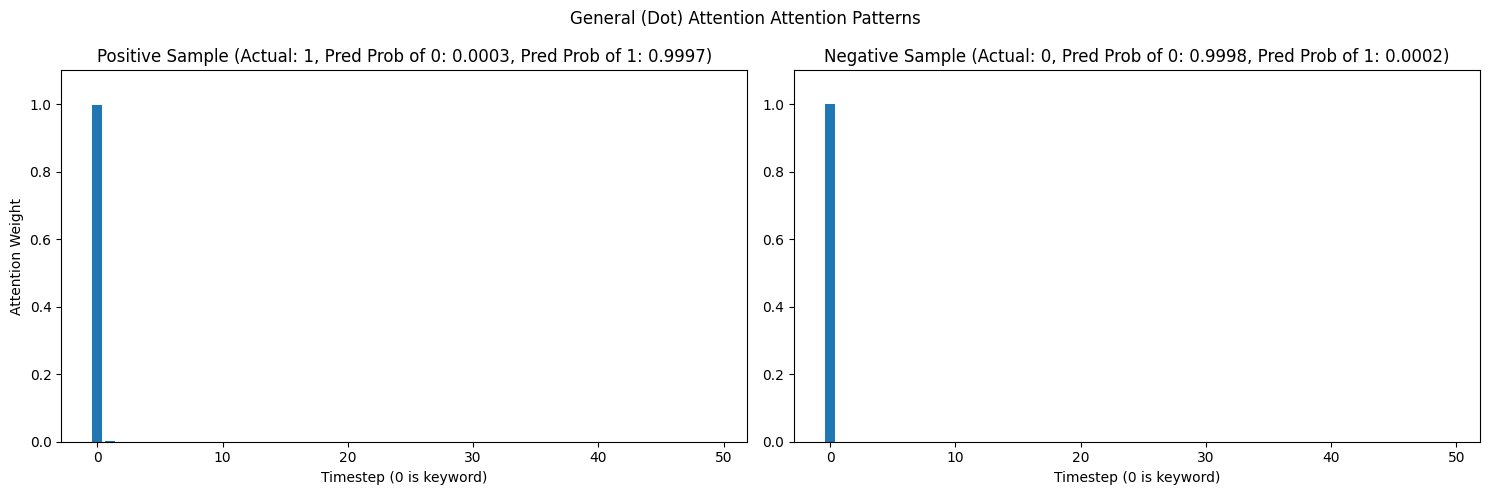

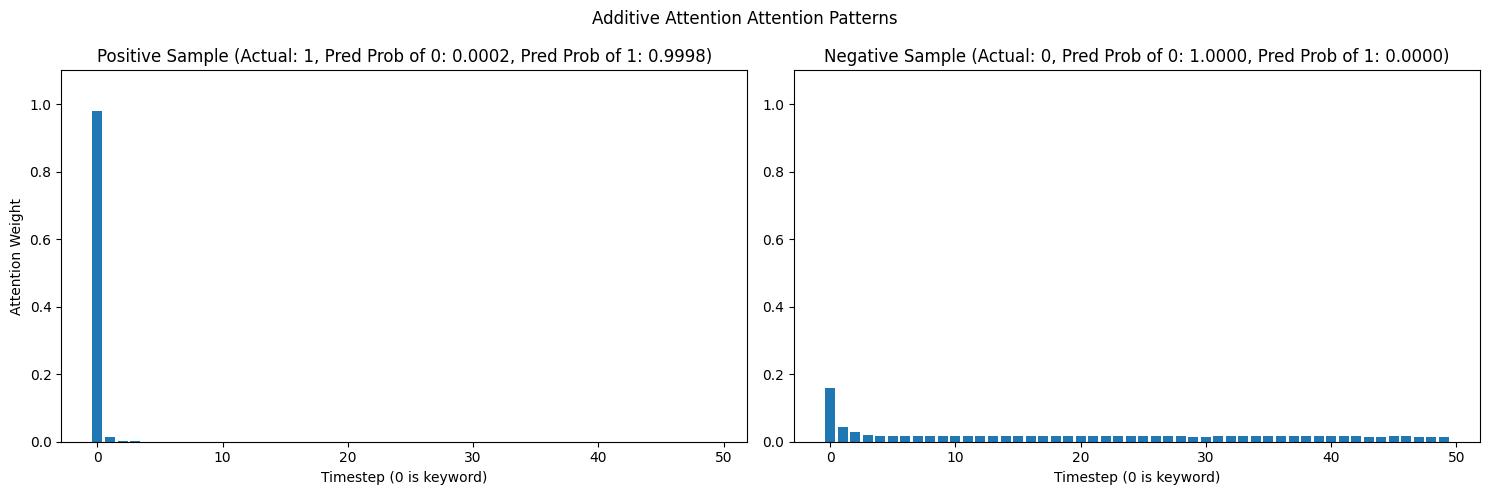

In [58]:
visualize_attention(dot_attn_model, "General (Dot) Attention")
visualize_attention(add_attn_model, "Additive Attention")

### Comparison Plot

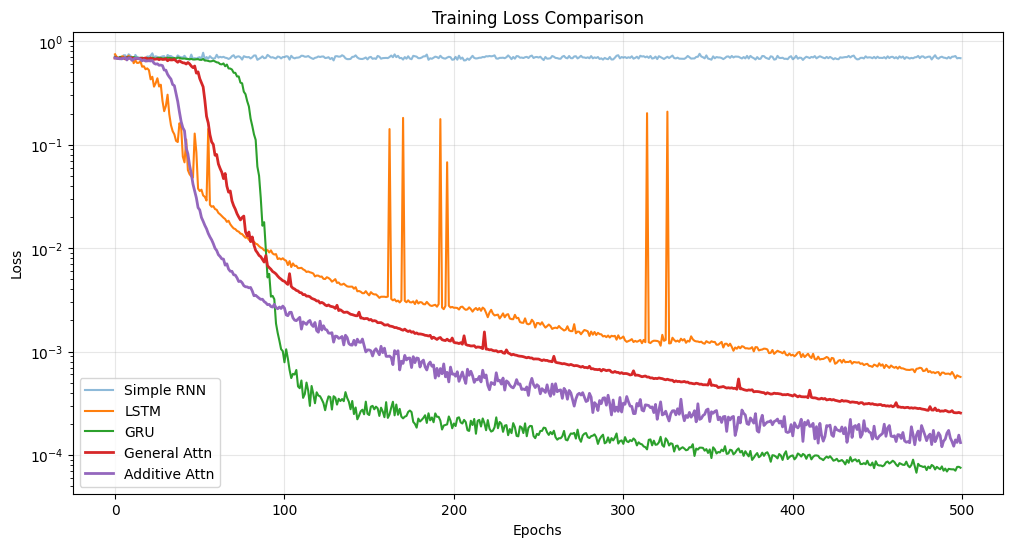

In [59]:
plt.figure(figsize=(12, 6))
plt.plot(rnn_hist, label="Simple RNN", alpha=0.5)
plt.plot(lstm_hist, label="LSTM")
plt.plot(gru_hist, label="GRU")
plt.plot(dot_hist, label="General Attn", linewidth=2)
plt.plot(add_hist, label="Additive Attn", linewidth=2)

plt.title("Training Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()